# GEC Fraud Detection (with Machine Learning) Hackathon 2023
## Mazin, Cici, Ryan, Owen

### The code below was executed on a local computer.  Some modifications such as directory names may have to change to make it operational on Colab.

In [2]:
base_path = './dataset'

# Tensor & pytorch imports
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


In [3]:
# CUDA Setup
UseCuda = True   #Switch to control the use of CUDA

if UseCuda and torch.cuda.is_available():
    print("Running on GPU: {}.".format(torch.cuda.get_device_name()))
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

Running on GPU: NVIDIA GeForce RTX 2060 SUPER.


In [4]:
# Dataloading and configuration

# Transform Settings to configure the pixels of the image
transform = transforms.Compose([transforms.Resize((224,183)), 
                                transforms.ToTensor()])

# This part of the code assumes three folders with 60% training, 20% validation 
# and 20% testing samples.

# This function associates the images in our folders with their respective labels
# and prepares them to be loaded into our ML model!!
train_dataset = torchvision.datasets.ImageFolder(base_path + '/Training', transform=transform)
val_dataset = torchvision.datasets.ImageFolder(base_path + '/Validation', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(base_path + '/Testing', transform=transform)

# Prepare Dataloader
batch_size = 20 # something you have to choose and optimize
num_workers = 1

# The next 3 lines take in the datasets that you prepared above and combine a 
# certain number of images (that number is the variable "batch_size") into one 
# single input for your ML model
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True, generator=torch.Generator(device='cuda'))

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True, generator=torch.Generator(device='cuda'))

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True, generator=torch.Generator(device='cuda'))

In [5]:
# Machine Learning Model

class CNN(nn.Module):
    
    def __init__(self, kernel=3, layer1_maps=16, layer2_maps=32, maxpool_kernel_stride=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, layer1_maps, kernel, 2) # in_channels, out_chanels, kernel_size, stride
        self.pool = nn.MaxPool2d(2, maxpool_kernel_stride) # kernel_size, stride
        self.conv2 = nn.Conv2d(layer1_maps, layer2_maps, kernel, 2) #in_channels, out_chanels, kernel_size, stride
        self.fc1 = nn.Linear(13 * 11 * layer2_maps, 1040)
        self.fc2 = nn.Linear(1040, 1)
        self.layer2_maps = layer2_maps
        
        # Initializing the weights of the network
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        

  # Forward pass
    def forward(self, x):
    
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 13 * 11 * self.layer2_maps)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        
        return x
  
print("Using Convolutional Neural Network Architecture")

Using Convolutional Neural Network Architecture


In [6]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        if UseCuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        with torch.no_grad():
            output = torch.sigmoid(model(imgs))  # converts to between 0 or 1
        
        for index in range(output.shape[0]):
            if (output[index] < 0.5 and labels[index] == 0) or (output[index] > 0.5 and labels[index] == 1):
                correct += 1
            total += 1
    return correct / total

In [92]:
# Training Method
def train(model, data, batch_size=20, num_epochs=1):

    # Load your training data here
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))

    # Choosing the criteria to measure error
    criterion = nn.BCEWithLogitsLoss()

    # Choosing a way to update the weights/parameters in our model
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    # Creating empty lists for storing values
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            
            if UseCuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
                
            print("Iteration # {}".format(n))
            
            out = model(imgs)             # forward pass
            out = out.reshape(out.shape[0])
            
            loss = criterion(out, labels.float()) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each weight/parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            print(loss)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            
            model.train(mode=False)
            train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
            val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
            model.train(mode = True)
            
            n += 1

    return iters, losses, train_acc, val_acc
    

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [93]:
model = CNN()

In [94]:
iters, losses, train_acc, val_acc = train(model, train_dataset, num_epochs=1)

Iteration # 0
tensor(0.6844, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Iteration # 1
tensor(0.6874, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Iteration # 2
tensor(0.7035, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Iteration # 3
tensor(0.6835, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Iteration # 4
tensor(0.6798, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Iteration # 5
tensor(0.6774, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Iteration # 6
tensor(0.6862, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Iteration # 7
tensor(0.6664, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Iteration # 8
tensor(0.6714, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Iteration # 9
tensor(0.6769, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Iteration # 10
tensor(0.6748, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Iteration # 11
tensor(0.6691, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Iteration # 12
tensor(0.6824, grad_fn=<BinaryCrossEntropyWithL

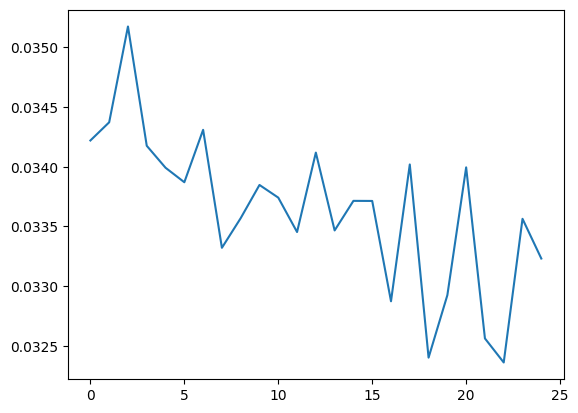

In [95]:
plt.plot(iters, losses)
plt.show()

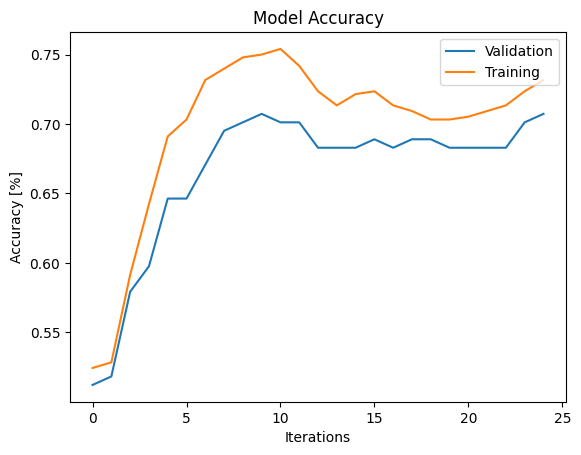

In [96]:
plt.plot(iters, val_acc, label='Validation')
plt.plot(iters, train_acc, label='Training')
plt.title("Model Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy [%]")
plt.legend(loc="upper right")
plt.show()

In [97]:
# Code for the final testing accuracy (end result)
test_accuracy = get_accuracy(model, test_loader)
print("Final Test Accuracy: {} %".format(100.0 * test_accuracy))

Final Test Accuracy: 72.5609756097561 %
